#Prerequisites

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import torch
device = "cudo:0" if torch.cuda.is_available() else "cpu"
from PIL import Image
import numpy as np

In [0]:
train = pd.read_csv("pwm_seq_200bp_train_set_10k.txt", sep = "\t",header=None)
train.columns = ["label", "sequence"]

test = pd.read_csv("pwm_seq_200bp_test_set_TOSEND.txt", sep = "\t",header=None)
test.columns = ["sequence"]

valid = pd.read_csv("pwm_seq_200bp_valid_set.txt", sep = "\t",header=None)
valid.columns = ["label", "sequence"]

#Check for imbalanced classes
###We observe that the classes are fairly balanced

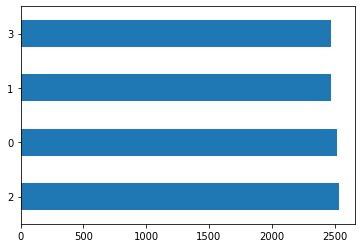

In [3]:
train.label.value_counts().plot(kind='barh')
#balanced classes

In [4]:
train.head()

,label,sequence
0,1,GTCCGGCGGGAAAAATGCTGCTTGCGCGCGCGCGCCTGTGCGCGCT...
1,0,TTGACTTTGCGCGCGCCGGATATAATCCGTTGGTGAACCAAAGAGA...
2,0,AGCCGCTAATTACCTACCTAGCAAATACGGCCGTTGGTGACAGCGC...
3,0,CAGCGCGCGCAGCGCGCAAGTCGCCGCTGTTCTGCGCGCCGCGCGC...
4,1,GACCCACGTGCGTCGGCGCGCACCCTATATACTAAGCCCCGTGACG...


#Check if all samples have the same characters
### We observe that although samples have different counts of each character, they have the same characters

In [0]:
def transfunc1(row):
    s = list(row.sequence)
    sets = list(set(s))
    sets.sort()
    joinedsets = ''.join(sets)
    return joinedsets

train['uniqechars'] = train.apply(transfunc1,axis=1)
test['uniquechars'] = test.apply(transfunc1,axis=1)
valid['uniquechars'] = valid.apply(transfunc1,axis=1)

In [6]:
test.head()

,sequence,uniquechars
0,GACCACGTGGAGGTCTGTAGGTTGCGCTTAGTCGGTGCGTGTATGA...,ACGT
1,TCAAATCTGTCCCCTGGTCCGCCCCCTGCTGGCCGAGCCTACCTCA...,ACGT
2,TTTTCCTATATACAGGGTGATAAGAATTTTCCGCGCGACACTGTAT...,ACGT
3,GTTTCCGAAAGAATTGCATTGCTGAACGCTCTTGAGGTCAGCCAGT...,ACGT
4,TGACCGGGGGCGCCTTAGTCGGGTCAAGCGATCGTGAAATTGCAGC...,ACGT


In [7]:
valid.uniquechars.unique()
#all sequences have the same characters

array(['ACGT'], dtype=object)

In [0]:
del train['uniqechars']

In [0]:
def transfunc1(row):
    s = list(row.sequence)
    return s.count('T')


train['countofT'] = train.apply(transfunc1,axis=1)

In [10]:
train.head()

,label,sequence,countofT
0,1,GTCCGGCGGGAAAAATGCTGCTTGCGCGCGCGCGCCTGTGCGCGCT...,38
1,0,TTGACTTTGCGCGCGCCGGATATAATCCGTTGGTGAACCAAAGAGA...,46
2,0,AGCCGCTAATTACCTACCTAGCAAATACGGCCGTTGGTGACAGCGC...,36
3,0,CAGCGCGCGCAGCGCGCAAGTCGCCGCTGTTCTGCGCGCCGCGCGC...,28
4,1,GACCCACGTGCGTCGGCGCGCACCCTATATACTAAGCCCCGTGACG...,43


#Check if there's any index in the 200-char long sequences with no changes
### This check was done with the intention of performing one-hot encoding or as a pre-requisite to k'mer features , but only for the indexes that change. I gave up the idea as I thought converting the sequences to images would be a better one.
### Observation - all 200 characters seem to vary across samples;no constant values

In [11]:
new = train['sequence'].apply(lambda x: pd.Series(list(x)))
new.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,G,T,C,C,G,G,C,G,G,G,A,A,A,A,A,T,G,C,T,G,C,T,T,G,C,G,C,G,C,G,C,G,C,G,C,C,T,G,T,G,...,A,A,A,A,A,A,G,T,T,G,T,T,A,T,C,T,C,C,G,A,G,C,C,G,A,A,G,C,G,C,G,C,G,C,C,C,C,T,G,C
1,T,T,G,A,C,T,T,T,G,C,G,C,G,C,G,C,C,G,G,A,T,A,T,A,A,T,C,C,G,T,T,G,G,T,G,A,A,C,C,A,...,T,T,C,A,C,T,G,G,G,C,G,C,G,C,C,G,C,G,C,C,C,T,G,C,T,C,A,A,G,G,C,G,C,G,C,T,G,G,T,G
2,A,G,C,C,G,C,T,A,A,T,T,A,C,C,T,A,C,C,T,A,G,C,A,A,A,T,A,C,G,G,C,C,G,T,T,G,G,T,G,A,...,A,A,C,A,A,T,G,C,T,A,T,G,C,G,C,G,C,G,C,C,A,G,T,T,A,T,G,G,C,T,C,C,C,C,A,A,G,A,G,G
3,C,A,G,C,G,C,G,C,G,C,A,G,C,G,C,G,C,A,A,G,T,C,G,C,C,G,C,T,G,T,T,C,T,G,C,G,C,G,C,C,...,A,T,C,T,A,T,G,G,G,C,G,C,G,C,C,A,T,G,C,G,C,G,C,G,A,G,G,C,G,G,T,T,C,A,T,G,G,G,A,A
4,G,A,C,C,C,A,C,G,T,G,C,G,T,C,G,G,C,G,C,G,C,A,C,C,C,T,A,T,A,T,A,C,T,A,A,G,C,C,C,C,...,C,A,T,T,T,A,G,C,T,T,A,C,A,C,G,T,G,T,G,A,T,A,T,A,T,A,T,G,T,C,C,T,C,T,G,A,A,T,A,T


In [0]:
t = pd.merge(train, new,left_index=True,right_index=True)

In [0]:
for i in t.columns:
  if len(t[i].unique())==1:
    print(i)
#no results returned. so all 200 chars change.

# Convert samples to images

### Encode characters to colors: A=0, C=0.3, G=0.7, T=1
### I convert each sequence to a grayscale image of size 200x200.



In [0]:
def transfunc2(row):
    s = list(row.sequence)
    news = [float(y) for y in [x.replace('A', '0').replace('C', '0.3').replace('G', '0.7').replace('T', '1') for x in s]]    
    mat = np.array([news,]*len(news))

    return mat

train['matrix'] = train.apply(transfunc2,axis=1)
test['matrix'] = test.apply(transfunc2,axis=1)
valid['matrix'] = valid.apply(transfunc2,axis=1)

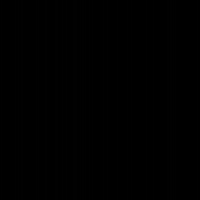

In [15]:
Image.fromarray(train.matrix.iloc[0].astype(np.uint8))
#visualizing to check

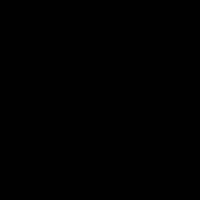

In [16]:
Image.fromarray(test.matrix.iloc[0].astype(np.uint8))
#visualizing to check test image

In [0]:
#for i,row in train.iterrows():
#  train.at[i, 'seqimage'] = Image.fromarray(row.matrix.astype(np.uint8))
# Storing images as I wasn't sure of using them or the encoded matrix

In [0]:
#from PIL import Image
#import numpy as np
 
#img = Image.fromarray((train.matrix.iloc[0]).astype(np.uint8))
#img.save('attempt.png')


In [0]:
#type(train.seqimage.iloc[0]) # seqimage is a series of PIL images

In [0]:
#type(train.matrix.iloc[0])

In [0]:
makepytdataset = train[['matrix','label']]
makepytdatasettest = test[['matrix']]
makepytdatasetvalid = valid[['matrix','label']]

In [21]:
makepytdatasetvalid.shape

(1000, 2)

In [22]:
makepytdatasettest.shape

(1000, 1)

In [23]:
makepytdataset.head()

,matrix,label
0,"[[0.7, 1.0, 0.3, 0.3, 0.7, 0.7, 0.3, 0.7, 0.7,...",1
1,"[[1.0, 1.0, 0.7, 0.0, 0.3, 1.0, 1.0, 1.0, 0.7,...",0
2,"[[0.0, 0.7, 0.3, 0.3, 0.7, 0.3, 1.0, 0.0, 0.0,...",0
3,"[[0.3, 0.0, 0.7, 0.3, 0.7, 0.3, 0.7, 0.3, 0.7,...",0
4,"[[0.7, 0.0, 0.3, 0.3, 0.3, 0.0, 0.3, 0.7, 1.0,...",1


In [24]:
makepytdatasetvalid.head()

,matrix,label
0,"[[1.0, 0.0, 1.0, 0.7, 1.0, 1.0, 0.0, 0.0, 0.0,...",0
1,"[[1.0, 1.0, 1.0, 1.0, 0.7, 1.0, 0.3, 0.3, 0.3,...",3
2,"[[0.3, 0.3, 0.0, 0.3, 0.3, 0.7, 0.0, 1.0, 0.0,...",2
3,"[[1.0, 0.7, 1.0, 1.0, 0.0, 0.3, 0.0, 0.0, 0.3,...",3
4,"[[0.3, 0.3, 0.7, 1.0, 0.7, 0.3, 0.3, 0.0, 0.3,...",1


In [25]:
makepytdatasettest.head()

,matrix
0,"[[0.7, 0.0, 0.3, 0.3, 0.0, 0.3, 0.7, 1.0, 0.7,..."
1,"[[1.0, 0.3, 0.0, 0.0, 0.0, 1.0, 0.3, 1.0, 0.7,..."
2,"[[1.0, 1.0, 1.0, 1.0, 0.3, 0.3, 1.0, 0.0, 1.0,..."
3,"[[0.7, 1.0, 1.0, 1.0, 0.3, 0.3, 0.7, 0.0, 0.0,..."
4,"[[1.0, 0.7, 0.0, 0.3, 0.3, 0.7, 0.7, 0.7, 0.7,..."


#Attempting Image classification in Pytorch

In [0]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader

import random;
import math;

In [0]:
class toy_set(Dataset):
  def __init__(self,data,transform=transforms.ToTensor()):
    self.X = data['matrix'].values
    self.Y = data['label'].values
    self.transform = transform;

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,idx):
    item = self.X[idx]
    label = self.Y[idx]

    if self.transform:
      item = self.transform(item)
    
    return (item,label)

In [0]:
class test_set(Dataset):
  def __init__(self,makepytdatasettest,transform=transforms.ToTensor()):
    self.X = makepytdataset['matrix'].values
    
    self.transform = transform;

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,idx):
    item = self.X[idx]
    

    if self.transform:
      item = self.transform(item)
    
    return item

In [0]:
test_dataset = test_set(makepytdatasettest)

In [0]:
train_dataset = toy_set(makepytdataset)
valid_dataset = toy_set(makepytdatasetvalid)

#Data Loader

In [0]:
#just checking
#for i in train_dataset:
  #print(i)

In [0]:
#from skimage import io, transform
#for i in range(len(train_dataset)):
#    sample = train_dataset[i]

#    print(i, sample[0].shape, sample[1])
#    Image.fromarray(sample[0],'RGB').save('test.png')
#    if i == 1:
        #plt.show()
#        break

In [0]:
num_epochs = 3;
batch_size = 1;
learning_rate = 0.0001;

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);

In [0]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False);

In [0]:
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);

#Check performance with a 2 layer CNN

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=5, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(47*47*8, 4)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
#instance of the Conv Net
cnn = CNN();
#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);

#Train

In [41]:
losses = [];
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #cnn.train(mode=True)
        #images = images.unsqueeze(1)
        #print(images.size())
        images = Variable(images.float())
        #print(labels)
        labels = Variable(labels)
        
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item());
        #losses.append(loss.data[0]);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item()))
    cnn.eval()
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = Variable(images.float())
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('Test Accuracy of the model on the 1000 validation images: %.4f %%' % (100 * correct / total))


Epoch : 1/3, Iter : 100/10000,  Loss: 3.3841
Epoch : 1/3, Iter : 200/10000,  Loss: 3.6822
Epoch : 1/3, Iter : 300/10000,  Loss: 0.1088
Epoch : 1/3, Iter : 400/10000,  Loss: 3.5254
Epoch : 1/3, Iter : 500/10000,  Loss: 1.4710
Epoch : 1/3, Iter : 600/10000,  Loss: 0.2682
Epoch : 1/3, Iter : 700/10000,  Loss: 0.4720
Epoch : 1/3, Iter : 800/10000,  Loss: 1.4309
Epoch : 1/3, Iter : 900/10000,  Loss: 0.6332
Epoch : 1/3, Iter : 1000/10000,  Loss: 5.4121
Epoch : 1/3, Iter : 1100/10000,  Loss: 0.2815
Epoch : 1/3, Iter : 1200/10000,  Loss: 1.2141
Epoch : 1/3, Iter : 1300/10000,  Loss: 2.7224
Epoch : 1/3, Iter : 1400/10000,  Loss: 2.5293
Epoch : 1/3, Iter : 1500/10000,  Loss: 1.4436
Epoch : 1/3, Iter : 1600/10000,  Loss: 0.3238
Epoch : 1/3, Iter : 1700/10000,  Loss: 0.5986
Epoch : 1/3, Iter : 1800/10000,  Loss: 0.7791
Epoch : 1/3, Iter : 1900/10000,  Loss: 1.4556
Epoch : 1/3, Iter : 2000/10000,  Loss: 3.4518
Epoch : 1/3, Iter : 2100/10000,  Loss: 5.2421
Epoch : 1/3, Iter : 2200/10000,  Loss: 3.85

#Predict on Test Set

In [0]:
cnn.eval()
test = []
correct = 0
total = 0
for images in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    #print(outputs)
    _, predicted = torch.max(outputs.data, 1)
    test.append(predicted)


In [0]:
finaltest = [x.item() for x in test]
pdtest = pd.DataFrame(finaltest)
pdtest.to_csv("mylist.csv")